In [1]:
import os
import json
from PIL import Image
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from transformers import DetrImageProcessor, DetrForObjectDetection
from torch.optim.lr_scheduler import CosineAnnealingLR
from collections import Counter
import numpy as np
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import tempfile
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from transformers import AutoImageProcessor, AutoConfig, AutoModelForObjectDetection

import json
import numpy as np
import albumentations as A 

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random


/home/ovgu/PycharmProjects/assignment2/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ovgu/PycharmProjects/assignment2/.venv/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Custom Dataset for AUAIR Object Detection
This class defines a custom PyTorch Dataset for loading and preprocessing the AUAIR object detection dataset, which follows a COCO-like annotation format. It also integrates Albumentations for data augmentation.

In [2]:
class AUAIRDataset(Dataset):
    def __init__(self, image_dir, annotation_path, processor, transforms=None):
        self.image_dir = image_dir
        self.processor = processor
        self.transforms = transforms
        with open(annotation_path, 'r') as f: data = json.load(f)
        self.entries = data["annotations"]
        self.class_names = data["categories"] # Keep for num_classes
        self.num_classes = len(self.class_names)

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        entry = self.entries[idx]
        image_path = os.path.join(self.image_dir, entry["image_name"])
        image = Image.open(image_path).convert("RGB")
        original_w, original_h = image.size

        # Prepare original annotations & filter invalid originals
        original_bboxes_coco = []
        original_class_labels = []
        if entry.get("bbox"):
            for obj in entry["bbox"]:
                width = obj.get("width", 0.0)
                height = obj.get("height", 0.0)
                class_id = obj.get("class")
                if width > 0 and height > 0 and class_id is not None:
                    # Assume types are correct, minimal conversion
                    original_bboxes_coco.append([float(obj["left"]), float(obj["top"]), float(width), float(height)])
                    original_class_labels.append(int(class_id))

        # Apply Albumentations transforms if they exist
        img_np = np.array(image)
        bboxes = original_bboxes_coco
        labels = original_class_labels
        if self.transforms:
            transformed = self.transforms(image=img_np, bboxes=bboxes, class_labels=labels)
            img_np = transformed['image']
            bboxes = transformed['bboxes']
            labels = transformed['class_labels']
            # Minimal filter after transform
            valid_indices = [i for i, bbox in enumerate(bboxes) if bbox[2] > 0 and bbox[3] > 0]
            bboxes = [bboxes[i] for i in valid_indices]
            labels = [labels[i] for i in valid_indices]

        # Prepare annotations for HF processor
        hf_annotations = [{"image_id": idx, "category_id": label, "bbox": bbox, "area": bbox[2] * bbox[3], "iscrowd": 0}
                          for bbox, label in zip(bboxes, labels)]
        target = {'image_id': idx, 'annotations': hf_annotations}

        # Process with HF processor
        image_to_process = Image.fromarray(img_np)
        encoding = self.processor(images=image_to_process, annotations=target, return_tensors="pt")

        # Finalize output structure (same as your original end part)
        encoding["pixel_values"] = encoding["pixel_values"].squeeze(0)
        if "pixel_mask" in encoding: encoding["pixel_mask"] = encoding["pixel_mask"].squeeze(0)
        processed_labels = encoding.pop('labels', None)
        encoding['orig_size'] = torch.tensor([original_h, original_w], dtype=torch.long)
        encoding['labels'] = processed_labels # Will be None if processor returns None

        return encoding

## Class Mappings for AUAIR Dataset

In [3]:
categories = ["Human", "Car", "Truck", "Van", "Motorbike", "Bicycle", "Bus", "Trailer"]

id2label = {i: name for i, name in enumerate(categories)}
label2id = {name: i for i, name in enumerate(categories)}

In [4]:
id2label

{0: 'Human',
 1: 'Car',
 2: 'Truck',
 3: 'Van',
 4: 'Motorbike',
 5: 'Bicycle',
 6: 'Bus',
 7: 'Trailer'}

## Custom Collate Function for Dataloader
It defines a custom_collate_fn used in the DataLoader to batch together multiple samples from the dataset.

In [5]:
def custom_collate_fn(batch):
    # batch is a list of dictionaries from your Dataset's __getitem__

    pixel_values = [item["pixel_values"] for item in batch] # Assuming shape is (3, H, W)
    pixel_values = torch.stack(pixel_values) # Stack -> (B, 3, H, W)

    labels = [item["labels"][0] for item in batch]

    orig_sizes = [item['orig_size'] for item in batch] # Get the tensor [h, w] for each item

    return {
        "pixel_values": pixel_values,
        "labels": labels, 
        "orig_size": orig_sizes
    }

## Data Augmentation with Albumentations
Designed to increase model robustness and generalization by applying different augmentation techniques such as flipping, rotating, blurring etc. Bounding box behavior is controlled using: format='coco': 
BBox format is [x_min, y_min, width, height].
With min_visibility=0.2 & min_area=25: bboxes that are too small or mostly invisible are filtered out. 

In [6]:
import albumentations as A

train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5), 
    A.ShiftScaleRotate(
        shift_limit=0.0625, 
        scale_limit=0.15, 
        rotate_limit=45, 
        p=0.7, 
        border_mode=0, 
        value=0 
    ),

    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),

    A.OneOf([ 
        A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        A.MotionBlur(blur_limit=(3, 7), p=0.5),
    ], p=0.2),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),

], bbox_params=A.BboxParams(
      format='coco',
      label_fields=['class_labels'],
      min_visibility=0.2, 
      min_area=25 
   )
)


val_test_transforms = A.Compose([], bbox_params=A.BboxParams(format='coco', label_fields=['class_labels'])) 


/home/ovgu/PycharmProjects/assignment2/.venv/lib/python3.8/site-packages/albumentations/core/composition.py:192: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


## Initialize Dataset and Processor
Handles image resizing and normalization compatible with the DETR model. Resizes images to 800×800 pixels.
Applies pixel normalization.

In [7]:
image_dir = "dataset/auair/images"
annotation_path = "dataset/auair/annotations.json"

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained("facebook/detr-resnet-50")

In [10]:
processor = AutoImageProcessor.from_pretrained(
    "facebook/detr-resnet-50",
    do_resize=True,
    do_normalize=True,
    size = {"height": 800, "width": 800}
)

In [11]:
dataset = AUAIRDataset(image_dir, annotation_path, processor)

In [12]:
train_full_dataset = AUAIRDataset(image_dir, annotation_path, processor, transforms=train_transforms)
val_test_full_dataset = AUAIRDataset(image_dir, annotation_path, processor, transforms=val_test_transforms)

## Stratified Dataset Splitting and DataLoader Initialization
This cell handles dataset splitting with multilabel stratification to ensure that all object classes are represented proportionally across splits. It also creates PyTorch DataLoaders for training, validation, and test sets.

In [13]:
VAL_SIZE = 0.15
TEST_SIZE = 0.15
RANDOM_STATE_1 = 42
RANDOM_STATE_2 = 43
BATCH_SIZE = 8 
NUM_WORKERS = 4 
PIN_MEMORY = torch.cuda.is_available()

def _get_img_class_vec(entry, num_classes):
    vec = [0] * num_classes
    if entry.get("bbox"):
        for obj in entry.get("bbox", []):
            class_idx = obj.get("class")
            if class_idx is not None:
                try:
                    class_idx = int(class_idx)
                    if 0 <= class_idx < num_classes: vec[class_idx] = 1
                except (ValueError, TypeError): pass
    return vec

num_classes = val_test_full_dataset.num_classes 
image_class_vectors = np.array([_get_img_class_vec(e, num_classes) for e in val_test_full_dataset.entries]) # Get vectors from entries

if image_class_vectors.size == 0: raise ValueError("Class vectors empty.")

temp_split_size = VAL_SIZE + TEST_SIZE
splitter1 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=temp_split_size, random_state=RANDOM_STATE_1)
train_idx, temp_idx = next(splitter1.split(np.zeros((len(image_class_vectors), 1)), image_class_vectors))

relative_test_size = TEST_SIZE / temp_split_size
splitter2 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=relative_test_size, random_state=RANDOM_STATE_2)
val_rel_idx, test_rel_idx = next(splitter2.split(np.zeros((len(temp_idx), 1)), image_class_vectors[temp_idx]))

temp_idx_arr = np.array(temp_idx)
val_idx = temp_idx_arr[val_rel_idx]
test_idx = temp_idx_arr[test_rel_idx]

train_dataset = Subset(train_full_dataset, train_idx)   
val_dataset = Subset(val_test_full_dataset, val_idx)      
test_dataset = Subset(val_test_full_dataset, test_idx)     

print(f"Dataset Split -> Train:{len(train_idx)} Val:{len(val_idx)} Test:{len(test_idx)}")
print(f"Proportions -> Train: {np.mean(image_class_vectors[train_idx], axis=0).round(3)}")
print(f"Val: {np.mean(image_class_vectors[val_idx], axis=0).round(3)}")
print(f"Test: {np.mean(image_class_vectors[test_idx], axis=0).round(3)}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

Dataset Split -> Train:22964 Val:4930 Test:4929
Proportions -> Train: [0.144 0.896 0.245 0.238 0.009 0.028 0.021 0.062]
Val: [0.143 0.894 0.245 0.237 0.01  0.028 0.021 0.062]
Test: [0.143 0.894 0.245 0.237 0.01  0.028 0.021 0.062]


##  Load and Configure Pretrained DETR Model
This cell loads the pretrained DETR (DEtection TRansformer) model from Facebook and adapts it to the AUAIR dataset.

In [14]:
model = AutoModelForObjectDetection.from_pretrained(
   "facebook/detr-resnet-50",
    num_labels=8,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)
model.to(device)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

## Visualize Images with Bounding Boxes

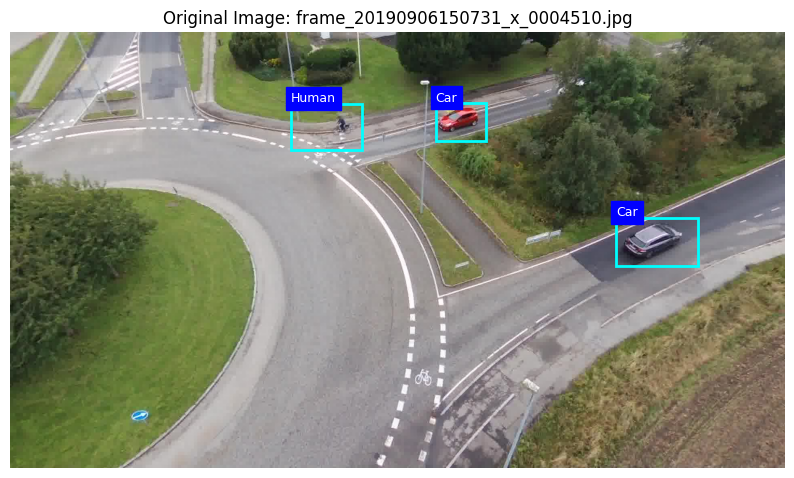

In [15]:
def show_original_image_with_boxes(dataset, index=None):
    if index is None:
        index = random.randint(0, len(dataset) - 1)

    entry = dataset.entries[index]
    image_path = os.path.join(dataset.image_dir, entry["image_name"])
    image = Image.open(image_path).convert("RGB")

    boxes = []
    class_labels = []

    for obj in entry["bbox"]:
        x_min = obj["left"]
        y_min = obj["top"]
        x_max = x_min + obj["width"]
        y_max = y_min + obj["height"]
        boxes.append([x_min, y_min, x_max, y_max])
        class_labels.append(obj["class"])

    # Convert image to displayable format
    image_np = np.array(image)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image_np)

    for box, label in zip(boxes, class_labels):
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height,
                                 linewidth=2, edgecolor='cyan', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min - 5, f"{dataset.class_names[label]}",
                color='white', backgroundcolor='blue', fontsize=9)

    ax.set_title(f"Original Image: {entry['image_name']}")
    plt.axis("off")
    plt.show()

# Show 3 examples from dataset
for _ in range(1):
    show_original_image_with_boxes(dataset)


## Format Predictions and Ground Truth in COCO Style
Converts predictions from model output (boxes, labels, scores) to COCO detection format. Converts ground truth from normalized center-based format to COCO absolute box format using original image size.

In [16]:
def prepare_coco_format(results, labels_batch, image_id_counter, ann_id_counter):
    """
    Formats model predictions and ground truth labels for a batch into COCO style lists.
    Handles normalized cxcywh format for ground truth boxes.
    """
    coco_results = []     
    coco_annotations = [] 
    coco_images = []      

    for j, (result, gt_label_dict) in enumerate(zip(results, labels_batch)):
        image_id = image_id_counter + j
        coco_images.append({"id": image_id})

        pred_boxes = result["boxes"].cpu().numpy()
        pred_scores = result["scores"].cpu().numpy()
        pred_labels = result["labels"].cpu().numpy()

        for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min
            if width > 0 and height > 0:
                coco_results.append({
                    "image_id": image_id,
                    "category_id": int(label),
                    "bbox": [float(x_min), float(y_min), float(width), float(height)],
                    "score": float(score),
                })

        try:
            orig_size = gt_label_dict['orig_size'].cpu().tolist()
            orig_h, orig_w = orig_size[0], orig_size[1]

            gt_boxes_normalized = gt_label_dict["boxes"].cpu().numpy()
            gt_labels = gt_label_dict["class_labels"].cpu().numpy()

            for box_norm, label in zip(gt_boxes_normalized, gt_labels):
                cx_norm, cy_norm, w_norm, h_norm = box_norm

                center_x = cx_norm * orig_w
                center_y = cy_norm * orig_h
                box_width = w_norm * orig_w
                box_height = h_norm * orig_h

                xmin = center_x - (box_width / 2)
                ymin = center_y - (box_height / 2)

                if box_width > 0 and box_height > 0:
                    coco_annotations.append({
                        "id": ann_id_counter,
                        "image_id": image_id,
                        "category_id": int(label),
                        "bbox": [float(xmin), float(ymin), float(box_width), float(box_height)],
                        "area": float(box_width * box_height),
                        "iscrowd": 0,
                    })
                    ann_id_counter += 1 
                else:
                    print(f"Warning: Skipping GT annotation with invalid calculated dimensions (w={box_width}, h={box_height}) for image_id {image_id}")

        except KeyError as e:
            print(f"Error processing ground truth for image_id {image_id}: Missing key {e}. Skipping GT.")
            continue
        except Exception as e:
            print(f"Error processing ground truth for image_id {image_id}: {e}. Skipping GT.")
            continue

    return coco_results, coco_annotations, coco_images, ann_id_counter

## DETR Evaluation with COCO Metrics and Per-Class AP

In [17]:
def evaluate_detr(model, processor, val_loader, id2label, device):
    model.eval()
    val_loss = 0
    all_results, all_annotations, all_images = [], [], []
    ann_id_counter = 1
    image_id_counter = 0
    per_class_ap_dict = {name: 0.0 for name in id2label.values()} # Initialize dict

    with torch.no_grad():
        for i, val_batch in enumerate(val_loader):

            pixel_values = val_batch["pixel_values"].to(device)
            # labels = [{k: v.to(device) for k, v in t.items()} for t in val_batch["labels"]]
            labels_for_loss = [{k: v.to(device) for k, v in t.items()} for t in val_batch["labels"]]
            ground_truth_labels = val_batch["labels"] 
            outputs = model(pixel_values=pixel_values, labels=labels_for_loss)
            val_loss += outputs.loss.item()
            
            
            if i % 100 == 0:
                avg_val_loss = val_loss / (i + 1)

            target_sizes = torch.stack(val_batch["orig_size"]).to(device)
            pred_outputs = model(pixel_values=pixel_values)
            results = processor.post_process_object_detection(pred_outputs, threshold=0.05, target_sizes=target_sizes)

            res, anns, imgs, ann_id_counter = prepare_coco_format(results, 
                                                                  ground_truth_labels, 
                                                                  image_id_counter, 
                                                                  ann_id_counter)
            all_results.extend(res)
            all_annotations.extend(anns)
            all_images.extend(imgs)

            image_id_counter += len(pixel_values)

    coco_gt = {
        "images": all_images,
        "annotations": all_annotations,
        "categories": [{"id": i, "name": name} for i, name in id2label.items()],
    }

    with tempfile.NamedTemporaryFile(mode="w+", suffix=".json", delete=False) as f_gt, \
         tempfile.NamedTemporaryFile(mode="w+", suffix=".json", delete=False) as f_dt:

        json.dump(coco_gt, f_gt)
        f_gt.flush()
        json.dump(all_results, f_dt)
        f_dt.flush()

        coco = COCO(f_gt.name)
        coco_dt = coco.loadRes(f_dt.name)

        coco_eval = COCOeval(coco, coco_dt, iouType="bbox")
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()

        mAP = coco_eval.stats[0]
        precision = coco_eval.eval['precision']
        
        ap_params = coco_eval.params

        cat_ids = sorted(id2label.keys()) # Should be [0, 1, ..., num_classes-1]
        if cat_ids != list(range(8)):
            print("Warning: Category IDs in id2label might not match 0..N-1 indices used by COCOeval.")

        for k_idx, cat_id in enumerate(cat_ids): 
            class_name = id2label[cat_id]
            p = precision[:, :, k_idx, 0, 2]
            ap = np.mean(p[p > -1]) if np.any(p > -1) else 0.0
            per_class_ap_dict[class_name] = ap
            print(f"- {class_name:<15}: {ap:.4f}")

    os.remove(f_gt.name)
    os.remove(f_dt.name)

    return val_loss / len(val_loader), mAP


## W&B Initialization

In [18]:
import time
import wandb

wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ovguyo to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Optimizer, Scheduler, and Weights & Biases (W&B) Setup

In [19]:
epochs = 20
log_interval = 250
eval_interval = 500
iter_num = 0
best_map = 0.0

optimizer = torch.optim.AdamW(model.parameters(), lr=2.5e-5, weight_decay=1e-4)

# CosineAnnealingLR: Smoothly reduces the learning rate to a minimum value over epochs.
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-7) 

config_wandb = {
    "learning_rate": optimizer.param_groups[0]['lr'],
    "weight_decay": optimizer.param_groups[0]['weight_decay'], 
    "epochs": epochs,
    "batch_size": train_loader.batch_size if hasattr(train_loader, 'batch_size') else 'N/A',
    "log_interval": log_interval,
    "eval_interval": eval_interval,
    "architecture": model.config.model_type if hasattr(model, 'config') else "DETR-variant",
    "grad_clip_norm": 0.1 
}

run_name = f"detr-run-{time.strftime('%Y%m%d-%H%M%S')}"
wandb.init(
    project="detr-aerial-detection", 
    config=config_wandb,
    name=run_name, 
    reinit=True  
)
print(f"Wandb run initialized: {run_name}")

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Wandb run initialized: detr-run-20250419-202640


## Full Training Loop
This cell contains the complete training loop for fine-tuning the DETR model on the AUAIR dataset. Runs evaluate_detr every eval_interval steps. Logs validation loss and mAP to W&B. Saves model checkpoints when a new best mAP is achieved.

In [ ]:
try:
    for epoch in range(epochs):
            model.train()
            total_loss = 0
            running_loss = 0

            print(f"\nEpoch {epoch+1}/{epochs}")
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} Training", unit="batch")

            for batch in progress_bar:
                pixel_values = batch["pixel_values"].to(device)
                labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]

                outputs = model(pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config_wandb["grad_clip_norm"])
                optimizer.step()

                total_loss += loss.item()
                running_loss += loss.item()
                iter_num += 1

                if iter_num % log_interval == 0:
                    avg_interval_loss = running_loss / log_interval
                    wandb.log({
                            "train/loss_log_interval": avg_interval_loss, 
                            "learning_rate": optimizer.param_groups[0]['lr'],
                            "step": iter_num
                            })
                    progress_bar.set_postfix({"loss": f"{avg_interval_loss:.4f}"})
                    running_loss = 0

                if iter_num % eval_interval == 0:
                    val_loss, mAP = evaluate_detr(model, processor, val_loader, id2label, device)
                    
                    # Log metrics to wandb (including the interval train loss)
                    wandb.log({
                        "validation/val_loss": val_loss,
                        "validation/mAP": mAP,
                        "step": iter_num
                    })

                    current_avg_train_loss_run = total_loss / iter_num # Avg loss over entire run so far
                    print(f"\nStep {iter_num}: Train Loss (Run Avg): {current_avg_train_loss_run:.4f},  Val Loss: {val_loss:.4f}, mAP: {mAP:.4f}")

                    if mAP > best_map:
                        best_map = mAP
                        wandb.summary["best_mAP"] = best_map 
                        save_path = f"best_detr_model_step_{iter_num}_map_{best_map:.4f}.pth"
                        torch.save(model.state_dict(), save_path)
                        print(f"  Saved new best model to {save_path}")


                    model.train()

            avg_epoch_loss = total_loss / len(train_loader)
            print(f"Epoch {epoch+1} completed. Average Training Loss: {avg_epoch_loss:.4f}")
            wandb.log({
                "train/loss_epoch": avg_epoch_loss,
                "epoch": epoch + 1 # Log against epoch number
            })

    print("Training finished.")
    if best_map != -1.0:
        print(f"Best mAP achieved: {best_map:.4f}")
        
except Exception as e:
    print(f"\nAn error occurred during the training loop: {e}")
    try:
        wandb.log({"error": str(e)})
    except Exception as wb_err:
        print(f"Could not log error to wandb: {wb_err}")
    raise 

finally:
    print("\nFinishing wandb run...")
    if wandb.run is not None:
        wandb.finish()
        print("Wandb run finished.")
    else:
        print("No active wandb run to finish.")


Epoch 1/20


Epoch 1 Training:   0%|                                                                                                                                                                        | 0/2871 [00:00<?, ?batch/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Epoch 1 Training:  17%|█████████████████████████▏                                                                                                                       | 499/2871 [03:50<17:12,  2.30batch/s, loss=2.0963]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=2.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=16.95s).
Accumulating evaluation results...
DONE (t=6.50s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.022
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 1 Training:  17%|████████████████████████▋                                                                                                                     | 500/2871 [08:48<59:13:53, 89.93s/batch, loss=2.0963]


Step 500: Train Loss (Run Avg): 2.3560,  Val Loss: 1.8629, mAP: 0.0060
  Saved new best model to best_detr_model_step_500_map_0.0060.pth


Epoch 1 Training:  35%|██████████████████████████████████████████████████▍                                                                                              | 999/2871 [12:21<14:01,  2.23batch/s, loss=1.8946]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.94s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.79s).
Accumulating evaluation results...


Epoch 1 Training:  35%|█████████████████████████████████████████████████                                                                                            | 1000/2871 [16:52<42:27:55, 81.71s/batch, loss=1.8946]

DONE (t=1.51s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.021
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.034
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.031
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.050
- Human          : 0.000

Epoch 1 Training:  52%|███████████████████████████████████████████████████████████████████████████▏                                                                    | 1499/2871 [20:32<09:32,  2.40batch/s, loss=1.8616]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.56s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=13.47s).
Accumulating evaluation results...
DONE (t=1.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.011
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.025
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 1 Training:  52%|█████████████████████████████████████████████████████████████████████████▋                                                                   | 1500/2871 [24:59<30:38:09, 80.44s/batch, loss=1.8616]

  Saved new best model to best_detr_model_step_1500_map_0.0073.pth


Epoch 1 Training:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1999/2871 [28:28<06:04,  2.39batch/s, loss=1.8339]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.51s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=11.88s).
Accumulating evaluation results...


Epoch 1 Training:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2000/2871 [32:55<19:27:45, 80.44s/batch, loss=1.8339]

DONE (t=1.91s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.025
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.036
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.034
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.052
- Human          : 0.000

Epoch 1 Training:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2499/2871 [36:24<02:36,  2.38batch/s, loss=1.7660]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.34s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.25s).
Accumulating evaluation results...


Epoch 1 Training:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2500/2871 [41:10<8:52:20, 86.09s/batch, loss=1.7660]

DONE (t=1.69s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.022
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.037
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.034
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.054
- Human          : 0.000

Epoch 1 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2871/2871 [43:45<00:00,  1.09batch/s, loss=1.7756]


Epoch 1 completed. Average Training Loss: 1.9426

Epoch 2/20


Epoch 2 Training:   0%|                                                                                                                                                                        | 0/2871 [00:00<?, ?batch/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Epoch 2 Training:   4%|██████▍                                                                                                                                          | 128/2871 [00:55<19:04,  2.40batch/s, loss=0.9025]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.25s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.48s).
Accumulating evaluation results...


Epoch 2 Training:   4%|██████▍                                                                                                                                       | 129/2871 [05:15<59:52:13, 78.60s/batch, loss=0.9025]

DONE (t=1.59s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.027
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.036
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.034
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.051
- Human          : 0.000

Epoch 2 Training:  22%|███████████████████████████████▋                                                                                                                 | 628/2871 [08:45<15:37,  2.39batch/s, loss=1.7407]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.09s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.44s).
Accumulating evaluation results...


Epoch 2 Training:  22%|███████████████████████████████                                                                                                               | 629/2871 [13:18<51:19:39, 82.42s/batch, loss=1.7407]

DONE (t=1.63s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.028
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.037
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.035
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.053
- Human          : 0.000

Epoch 2 Training:  39%|████████████████████████████████████████████████████████▌                                                                                       | 1128/2871 [16:55<12:09,  2.39batch/s, loss=1.7269]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.70s).
Accumulating evaluation results...
DONE (t=1.59s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.029
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 2 Training:  39%|███████████████████████████████████████████████████████▍                                                                                     | 1129/2871 [21:17<38:12:58, 78.98s/batch, loss=1.7269]

  Saved new best model to best_detr_model_step_4000_map_0.0083.pth


Epoch 2 Training:  57%|█████████████████████████████████████████████████████████████████████████████████▋                                                              | 1628/2871 [24:46<09:01,  2.30batch/s, loss=1.6532]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.28s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.35s).
Accumulating evaluation results...


Epoch 2 Training:  57%|████████████████████████████████████████████████████████████████████████████████                                                             | 1629/2871 [29:08<27:17:18, 79.10s/batch, loss=1.6532]

DONE (t=1.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.030
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.041
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.034
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.060
- Human          : 0.000

Epoch 2 Training:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 2128/2871 [32:38<05:11,  2.39batch/s, loss=1.6543]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.09s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.58s).
Accumulating evaluation results...
DONE (t=1.33s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.019
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.046
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 2 Training:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2129/2871 [36:56<16:00:58, 77.71s/batch, loss=1.6543]

  Saved new best model to best_detr_model_step_5000_map_0.0123.pth


Epoch 2 Training:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2628/2871 [40:25<01:41,  2.39batch/s, loss=1.6764]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.32s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.04s).
Accumulating evaluation results...


Epoch 2 Training:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2629/2871 [44:47<5:18:47, 79.04s/batch, loss=1.6764]

DONE (t=1.70s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.041
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.055
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.036
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.077
- Human          : 0.000

Epoch 2 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2871/2871 [46:28<00:00,  1.03batch/s, loss=1.6764]


Epoch 2 completed. Average Training Loss: 1.6883

Epoch 3/20


Epoch 3 Training:   0%|                                                                                                                                                                        | 0/2871 [00:00<?, ?batch/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Epoch 3 Training:   9%|████████████▉                                                                                                                                    | 257/2871 [01:49<18:14,  2.39batch/s, loss=1.5930]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.38s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=11.47s).
Accumulating evaluation results...
DONE (t=1.83s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.018
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.017
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.043
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 3 Training:   9%|████████████▊                                                                                                                                 | 258/2871 [06:13<57:48:34, 79.65s/batch, loss=1.5930]

  Saved new best model to best_detr_model_step_6000_map_0.0129.pth


Epoch 3 Training:  26%|██████████████████████████████████████▏                                                                                                          | 757/2871 [09:43<14:46,  2.38batch/s, loss=1.6336]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.95s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.99s).
Accumulating evaluation results...


Epoch 3 Training:  26%|█████████████████████████████████████▍                                                                                                        | 758/2871 [14:03<46:01:48, 78.42s/batch, loss=1.6336]

DONE (t=1.52s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.021
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.054
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.065
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.038
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.089
- Human          : 0.002

Epoch 3 Training:  44%|███████████████████████████████████████████████████████████████                                                                                 | 1257/2871 [17:32<11:14,  2.39batch/s, loss=1.6357]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.27s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.45s).
Accumulating evaluation results...
DONE (t=1.60s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.045
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.024
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.024
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.057
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 3 Training:  44%|█████████████████████████████████████████████████████████████▊                                                                               | 1258/2871 [21:53<35:19:15, 78.83s/batch, loss=1.6357]

  Saved new best model to best_detr_model_step_7000_map_0.0155.pth


Epoch 3 Training:  61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1757/2871 [25:22<07:46,  2.39batch/s, loss=1.6301]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.17s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.73s).
Accumulating evaluation results...


Epoch 3 Training:  61%|██████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1758/2871 [29:42<24:15:28, 78.46s/batch, loss=1.6301]

DONE (t=1.51s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.043
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.020
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.024
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.059
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.068
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.039
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.090
- Human          : 0.007

Epoch 3 Training:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2257/2871 [33:11<04:16,  2.39batch/s, loss=1.6204]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.42s).
Accumulating evaluation results...
DONE (t=1.78s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.027
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.037
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.082
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 3 Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2258/2871 [37:34<13:29:20, 79.22s/batch, loss=1.6204]

  Saved new best model to best_detr_model_step_8000_map_0.0182.pth


Epoch 3 Training:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2757/2871 [41:03<00:47,  2.39batch/s, loss=1.6199]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.35s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.61s).
Accumulating evaluation results...


Epoch 3 Training:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2758/2871 [45:26<2:29:30, 79.38s/batch, loss=1.6199]

DONE (t=1.84s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.054
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.026
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.040
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.080
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.056
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.121
- Human          : 0.014

Epoch 3 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2871/2871 [46:13<00:00,  1.04batch/s, loss=1.6199]


Epoch 3 completed. Average Training Loss: 1.6181

Epoch 4/20


Epoch 4 Training:   0%|                                                                                                                                                                        | 0/2871 [00:00<?, ?batch/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Epoch 4 Training:  13%|███████████████████▍                                                                                                                             | 386/2871 [02:43<17:19,  2.39batch/s, loss=1.5557]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.98s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.80s).
Accumulating evaluation results...
DONE (t=1.60s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.061
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.028
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.039
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.080
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 4 Training:  13%|███████████████████▏                                                                                                                          | 387/2871 [07:02<54:02:36, 78.32s/batch, loss=1.5557]

  Saved new best model to best_detr_model_step_9000_map_0.0202.pth


Epoch 4 Training:  31%|████████████████████████████████████████████▋                                                                                                    | 886/2871 [10:33<13:59,  2.36batch/s, loss=1.5321]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.73s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=6.28s).
Accumulating evaluation results...
DONE (t=1.16s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.066
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.036
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.049
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.101
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 4 Training:  31%|███████████████████████████████████████████▊                                                                                                  | 887/2871 [14:52<43:10:47, 78.35s/batch, loss=1.5321]

  Saved new best model to best_detr_model_step_9500_map_0.0224.pth


Epoch 4 Training:  48%|█████████████████████████████████████████████████████████████████████▌                                                                          | 1386/2871 [18:30<10:28,  2.36batch/s, loss=1.5759]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.50s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=12.27s).
Accumulating evaluation results...
DONE (t=2.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.039
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.050
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.102
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 4 Training:  48%|████████████████████████████████████████████████████████████████████                                                                         | 1387/2871 [23:06<34:16:04, 83.13s/batch, loss=1.5759]


Step 10000: Train Loss (Run Avg): 0.2167,  Val Loss: 1.5298, mAP: 0.0268
  Saved new best model to best_detr_model_step_10000_map_0.0268.pth


Epoch 4 Training:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1886/2871 [26:45<07:31,  2.18batch/s, loss=1.5464]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.51s).
Accumulating evaluation results...


Epoch 4 Training:  66%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1887/2871 [31:12<22:02:10, 80.62s/batch, loss=1.5464]

DONE (t=1.74s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.070
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.035
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.046
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.099
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.108
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.071
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.141
- Human          : 0.022

Epoch 4 Training:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2386/2871 [34:51<03:41,  2.19batch/s, loss=1.6038]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.17s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.23s).
Accumulating evaluation results...
DONE (t=1.62s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.075
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.042
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.061
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.117
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 4 Training:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2387/2871 [39:21<10:56:53, 81.43s/batch, loss=1.6038]

  Saved new best model to best_detr_model_step_11000_map_0.0269.pth


Epoch 4 Training:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2686/2871 [41:32<01:19,  2.32batch/s, loss=1.5797]

In [23]:
MODEL_SAVE_PATH = "best_detr_model_step_27000_map_0.0362.pth" 
ORIGINAL_CHECKPOINT = "facebook/detr-resnet-50"

MODEL_LOADER_CLASS = AutoModelForObjectDetection

processor = AutoImageProcessor.from_pretrained(ORIGINAL_CHECKPOINT)

test_model = MODEL_LOADER_CLASS.from_pretrained(
        ORIGINAL_CHECKPOINT,
        num_labels=8,
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True 
    )
state_dict = torch.load(MODEL_SAVE_PATH, map_location='cpu') 
test_model.load_state_dict(state_dict)
print("Loaded fine-tuned weights into model.")

test_model.to(device)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

Loaded fine-tuned weights into model.


/tmp/ipykernel_1248129/119018225.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MODEL_SAVE_PATH, map_location='cpu')


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

## Evaluation on Test Set

In [24]:
test_loss, test_mAP = evaluate_detr(test_model, processor, test_loader, id2label, device)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.81s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.73s).
Accumulating evaluation results...
DONE (t=1.35s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.014
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [25]:
# --- Report Results ---
print("\n--- Test Set Results ---")
print(f" Average Loss: {test_loss:.4f}")
print(f" mAP @[IoU=0.50:0.95]: {test_mAP:.4f}")
print("------------------------")


--- Test Set Results ---
 Average Loss: 2.8513
 mAP @[IoU=0.50:0.95]: 0.0018
------------------------


In [44]:
import requests

def infer_single_image_short(image_path_or_url, model, original_checkpoint, num_classes, id2label, confidence_threshold=0.5, device_str='auto'):
    """
    Loads model, runs inference on one image, returns detections.
    """
    if device_str == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device_str)

    try:
        processor = AutoImageProcessor.from_pretrained(original_checkpoint)
        label2id = {name: id_ for id_, name in id2label.items()}
        model.eval()
    except Exception as e:
        print(f"Error loading model/processor: {e}")
        raise 

    try:
        if image_path_or_url.startswith('http'):
            image = Image.open(requests.get(image_path_or_url, stream=True).raw).convert("RGB")
        else:
            if not os.path.exists(image_path_or_url):
                raise FileNotFoundError(f"Image file not found: {image_path_or_url}")
            image = Image.open(image_path_or_url).convert("RGB")
    except Exception as e:
        print(f"Error loading image: {e}")
        raise # Re-raise the exception

    inputs = processor(images=image, return_tensors="pt")
    pixel_values = inputs['pixel_values'].to(device)
    original_height, original_width = image.size[1], image.size[0]
    target_sizes = torch.tensor([[original_height, original_width]], device=device)

    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)

    results = processor.post_process_object_detection(
        outputs,
        threshold=confidence_threshold,
        target_sizes=target_sizes
    )

    detections = results[0] 
    return detections['scores'], detections['labels'], detections['boxes']


In [52]:
scores, labels, boxes = infer_single_image_short(
     image_path_or_url="dataset/auair/images/frame_20190829091111_x_0000165.jpg",
     model=model,
     original_checkpoint="facebook/detr-resnet-50", 
     num_classes=8, 
     id2label=id2label, 
     confidence_threshold=0.5,
     device_str='cuda')

In [53]:
scores

tensor([0.9399, 0.6670, 0.6711, 0.9640], device='cuda:0')

In [54]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import requests # If loading image from URL
import os

def visualize_detections(image_path_or_url, scores, labels, boxes, id2label, confidence_threshold=0.0):
    try:
        if image_path_or_url.startswith('http'):
            # Load image from URL
            image = Image.open(requests.get(image_path_or_url, stream=True).raw).convert("RGB")
        else:
            # Load image from local path
            if not os.path.exists(image_path_or_url):
                 print(f"Error: Image file not found at {image_path_or_url}")
                 return
            image = Image.open(image_path_or_url).convert("RGB")
    except Exception as e:
        print(f"Error loading image for visualization: {e}")
        return

    # --- Prepare Plot ---
    fig, ax = plt.subplots(1, figsize=(12, 12)) # Adjust figure size as needed
    ax.imshow(image)
    ax.axis('off') # Turn off axes
    title = f"Detected Objects"
    # Add threshold to title if provided and meaningful
    if confidence_threshold > 0.0:
        title += f" (Score >= {confidence_threshold})"
    ax.set_title(title)

    # --- Define Colors ---
    # Create a list of colors for different classes
    num_classes = len(id2label)
    # Example color list, extend if you have many classes or use a colormap
    colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
              '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',
              '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
              '#000075', '#a9a9a9'] # Add more colors if needed
    colors = (colors * (num_classes // len(colors) + 1))[:num_classes]

    # --- Draw Detected Boxes ---
    # Ensure tensors are on CPU for numpy conversion and iteration
    scores = scores.cpu()
    labels = labels.cpu()
    boxes = boxes.cpu()

    if len(boxes) == 0:
        print("No detections passed the threshold to visualize.")
    else:
        print(f"Visualizing {len(boxes)} detections...")

    for score_val, label_id_val, box_val in zip(scores, labels, boxes):
        score = score_val.item() # Get float value
        label_id = label_id_val.item() # Get integer value
        box = box_val.numpy() # Convert box to numpy array [xmin, ymin, xmax, ymax]

        # Get class name and corresponding color
        class_name = id2label.get(label_id, f"ID_{label_id}?") # Get name from map
        color = colors[label_id % len(colors)] # Assign color safely

        # Extract coordinates and calculate width/height
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin

        # Create a Rectangle patch
        rect = patches.Rectangle(
            (xmin, ymin), width, height,
            linewidth=2,
            edgecolor=color,
            facecolor='none' # No fill
        )
        # Add the rectangle to the plot
        ax.add_patch(rect)

        # Create and add label text with score
        label_text = f'{class_name}: {score:.2f}'
        ax.text(
            xmin, ymin - 5, # Position text slightly above the box top-left corner
            label_text,
            color='white', # Text color
            fontsize=8,
            bbox=dict(facecolor=color, alpha=0.7, pad=0.2, edgecolor='none') # Background box for text
        )

    plt.tight_layout() 
    plt.show() 

Visualizing 4 detections...


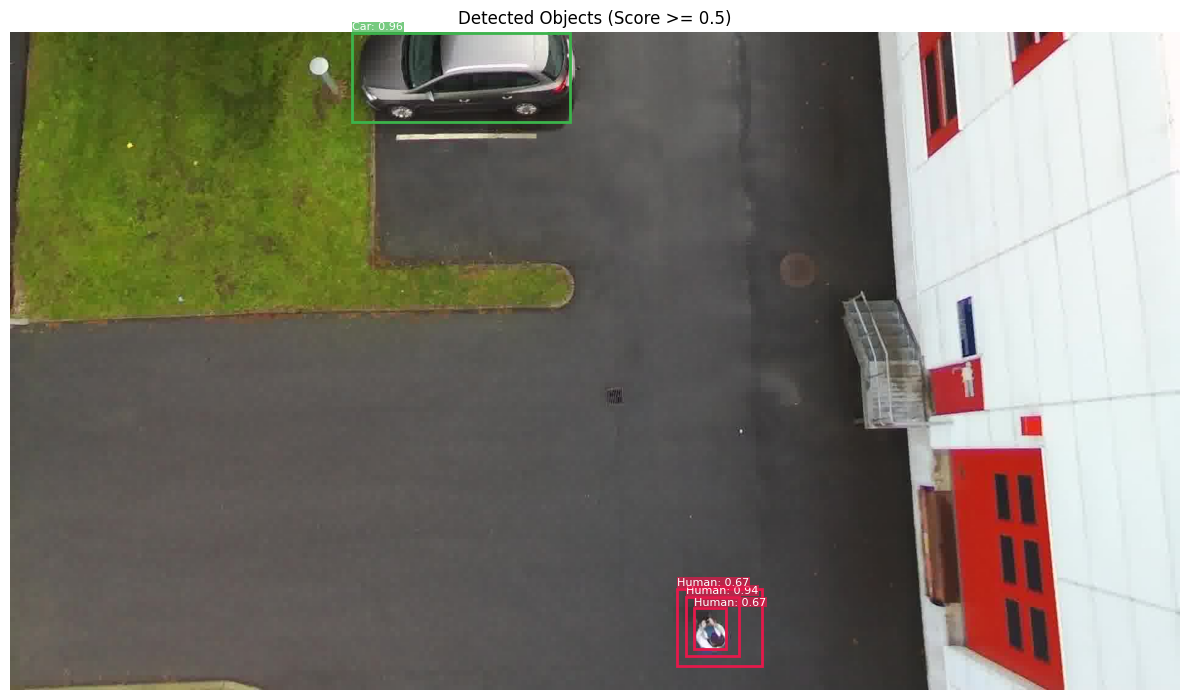

In [55]:
visualize_detections("dataset/auair/images/frame_20190829091111_x_0000165.jpg", scores, labels, boxes, id2label, 0.5)